In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [273]:
import warnings
warnings.filterwarnings('ignore')

In [274]:
df=pd.read_csv('airline-passenger-traffic (1).csv')

In [275]:
df.head()

,1949-01,112
0,1949-02,118.0
1,1949-03,132.0
2,1949-04,129.0
3,1949-05,121.0
4,1949-06,135.0


In [276]:
df.columns=['Month','Passengers']

In [277]:
df.shape

(143, 2)

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       143 non-null    object 
 1   Passengers  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [279]:
# Month is in object format so change to date
df['Month']=pd.to_datetime(df['Month'])

In [280]:
# set index as month
df.set_index(['Month'],inplace=True)
df.head()

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1949-02-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  139 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [282]:
df.head()

,Passengers
Month,
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0


In [283]:
# checking missing value
df.isnull().sum()

Passengers    4
dtype: int64

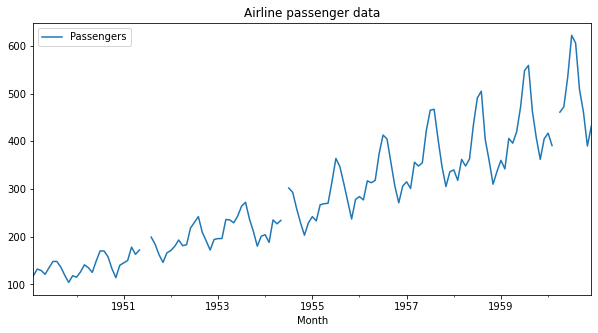

In [284]:
# before imputing null values we have to plot time series data
plt.rcParams['figure.figsize']=10,5
df.plot()
plt.title("Airline passenger data")
plt.show()

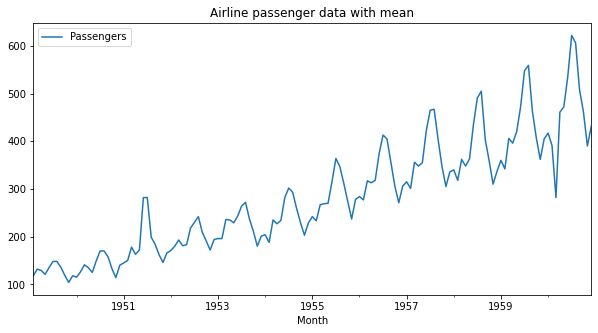

In [285]:
# try replace with mean
df.fillna(df['Passengers'].mean()).plot(figsize=(10,5))
plt.title("Airline passenger data with mean")
plt.show()

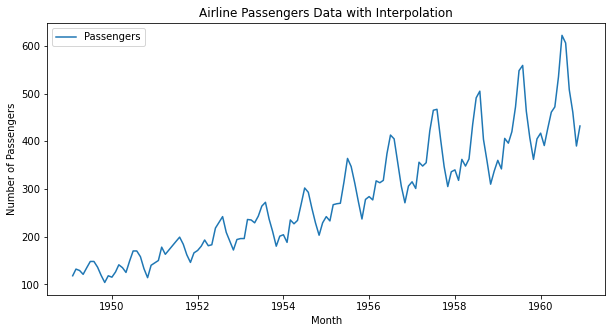

In [286]:
# from plot we can see that mean cannot fit the missing values and also replacing missing values with same mean everywhere is not fair
#check for interpolation
plt.figure(figsize=(10,5))
plt.plot(df['Passengers'].interpolate(model="linear"),label="Passengers")
plt.legend()
plt.title('Airline Passengers Data with Interpolation')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.show()

we found that interpolation can replace missing values

In [287]:
# Replace passenger missing values with interpolated values
df['Passengers']=df['Passengers'].fillna(df['Passengers'].interpolate(model="Linear"))

In [288]:
df.isnull().sum()

Passengers    0
dtype: int64

In [289]:
## Outliers treatment

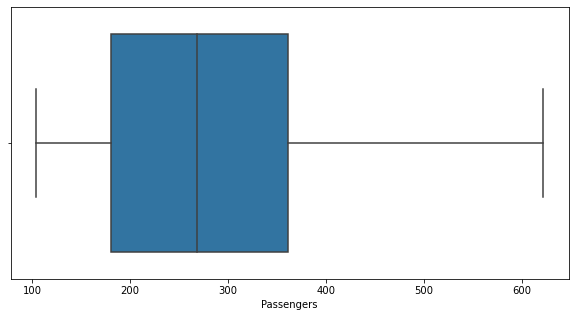

In [290]:
# check for outliers using boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=df,x='Passengers')
plt.show()

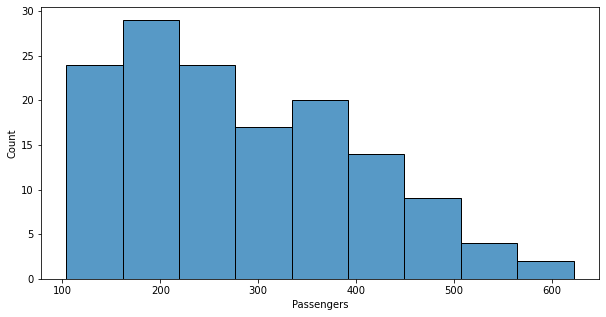

In [291]:
# histogram plot
sns.histplot(df['Passengers'])
plt.show()

So we found that no outliers are there in our data

### Time Series Decomposition -to find components of time series


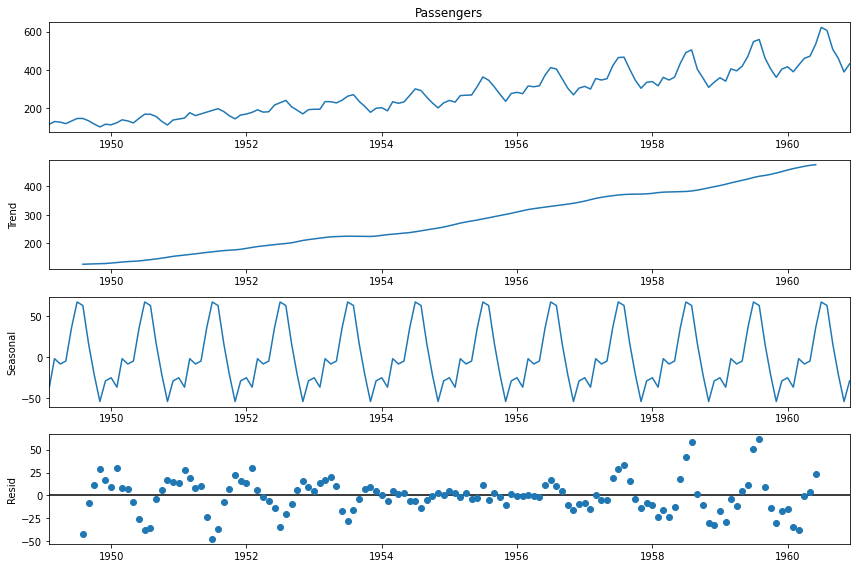

In [292]:
## Additive Seasonal decomposition
plt.rcParams['figure.figsize']=12,8
import statsmodels.api as sm
Additive_decomposition=sm.tsa.seasonal_decompose(df.Passengers,model="additive")
fig=Additive_decomposition.plot()
plt.show()


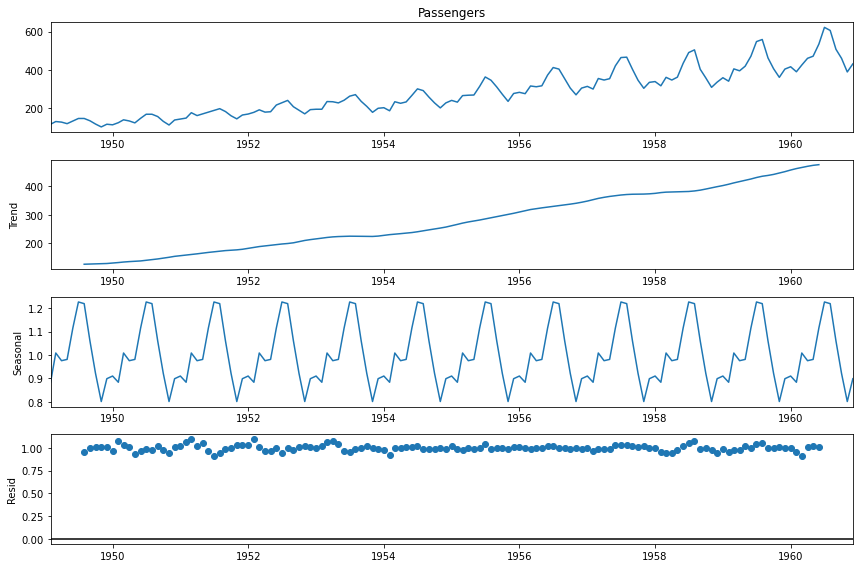

In [293]:
# Multiplicative Seasonal decomposition
decomposition=sm.tsa.seasonal_decompose(df.Passengers,model='multiplicative')
fig=decomposition.plot()
plt.show()

 Now residual are random than when used additive decomposition

### Model Building and Evaluation

#### Train_test split

In [294]:
train_len=120
train=df[:train_len]
test=df[train_len:]

In [295]:
train.shape,test.shape

((120, 1), (23, 1))

### Naive Method-simplest forecasting method
It assumes that the forecast for any future time point is the same as the last observed value.


In [296]:
y_naive=test.copy()
y_naive['naive_forecast']=train['Passengers'][-1]

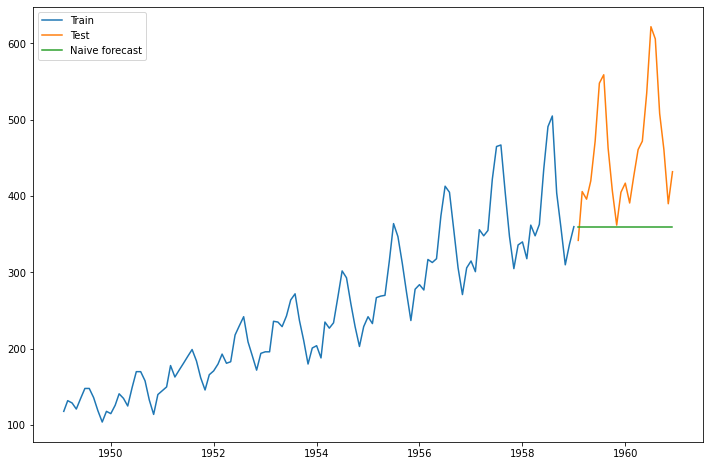

In [297]:
#plot train,test,forecast
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_naive['naive_forecast'],label="Naive forecast")
plt.legend(loc="best")
plt.show()

Here forecast done by simply extrapolate last observed value and it underforecast number of passengers

In [298]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_naive['naive_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_naive['naive_forecast']))/test['Passengers'])*100,2)
result=pd.DataFrame({'Method':['Naive_method'],'RMSE':[RMSE],'MAPE':[MAPE]})
result

,Method,RMSE,MAPE
0,Naive_method,121.4,19.68


### Simple Average Method

In [299]:
simple_average=test.copy()
simple_average['avg_forecast']=train.Passengers.mean()

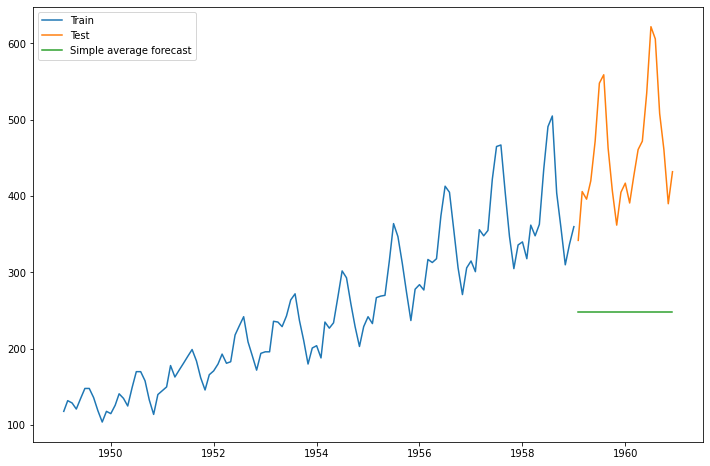

In [300]:
#plot train,test,forecast
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(simple_average['avg_forecast'],label="Simple average forecast")
plt.legend(loc="best")
plt.show()

It gives very low forecast than the original test data.Also it doesnt capture seasonality

In [301]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],simple_average['avg_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-simple_average['avg_forecast']))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_Average'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.4,19.68
0,Simple_Average,221.2,44.36


### Simple Moving Average(SMA)

SMA is a widely used statistical measure in time series analysis that helps to smooth out short-term fluctuations and highlight longer-term trends or cycles. It calculates the average of a set of values over a specific number of periods.

In [302]:
## here we are considering whole dataset so that we can check whats trend 
y_sma=df.copy()
ma_window=12
y_sma['sma_forecast']=df["Passengers"].rolling(ma_window).mean()
# we need last 2 years forecast to be the last observed mean of train set
y_sma['sma_forecast'][train_len:]=y_sma['sma_forecast'][train_len-1]

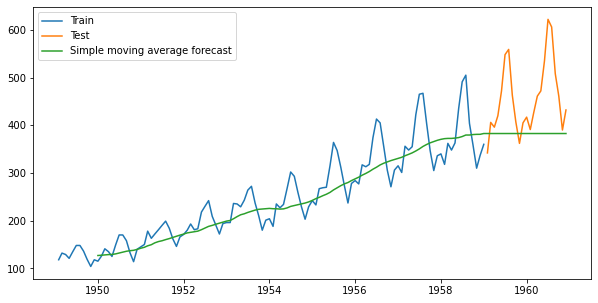

In [303]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_sma['sma_forecast'],label="Simple moving average forecast")
plt.legend(loc="best")
plt.show()

if we change moving_window to 6 or 3 months instead of 12 then we can capture some seaonal fluctuations also but at the cost of more noise into model.so we proceed with 12months

In [304]:
#### Evaluation of model
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_sma['sma_forecast'][train_len:])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_sma['sma_forecast'][train_len:]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_Moving_Average'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67


### Simple Exponential Smoothing
Simple Exponential Smoothing is a powerful tool for forecasting time series data when there are no significant trends or seasonal patterns. It smooths the data by weighting recent observations more heavily and is ideal for short-term forecasting of stable data.

In [305]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model=SimpleExpSmoothing(train['Passengers'])
model_fit=model.fit(smoothing_level=0.2,optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 118.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [306]:
# forecast
y_ses=test.copy()
y_ses['ses_forecast']=model_fit.forecast(24)

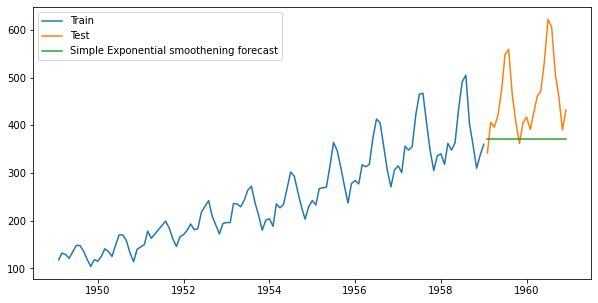

In [307]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_ses['ses_forecast'],label="Simple Exponential smoothening forecast")
plt.legend(loc="best")
plt.show()

In [308]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_ses['ses_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_ses['ses_forecast']))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple Exponential Smoothening'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55


### Holts Exponential Smoothing
Holt's Exponential Smoothing (also called double exponential smoothing) is an extension of simple exponential smoothing that allows for forecasting time series data with a trend. It incorporates two components:

In [309]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model=ExponentialSmoothing(train["Passengers"],trend='additive',seasonal=None,seasonal_periods=12)

In [310]:
model_fit=model.fit(smoothing_level=0.2,smoothing_slope=0.01,optimized=False)
print(model_fit.params)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 131.93333333333325, 'initial_trend': -0.5333333333333257, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [311]:
y_holt=test.copy()
y_holt['holt_forecast']=model_fit.forecast(24)

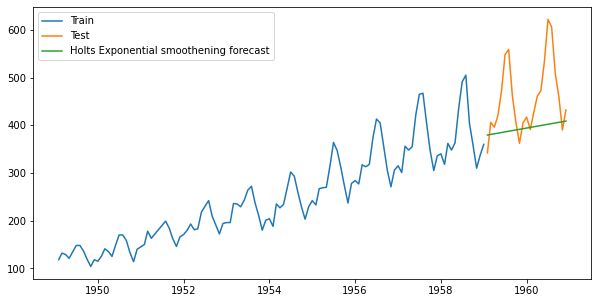

In [312]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_holt['holt_forecast'],label="Holts Exponential smoothening forecast")
plt.legend(loc="best")
plt.show()

In [313]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_holt['holt_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_holt['holt_forecast']))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':["Holt's Exponential Smoothening"],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82


### Holt-winters Exponential Smoothing
The Holt-Winters method, also known as Triple Exponential Smoothing, is a time series forecasting technique that extends Exponential Smoothing to capture trend and seasonality in addition to the level of the data. It is particularly useful for time series data with both trend and seasonal components.

In [314]:
y_holt_winters_add=test.copy()
model=ExponentialSmoothing(train["Passengers"],seasonal_periods=12,trend='add',seasonal='add')
model_fit=model.fit(optimized=True)
print(model_fit.params)

{'smoothing_level': 0.23597751099279277, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.7640224890072073, 'damping_trend': nan, 'initial_level': 119.08705640781227, 'initial_trend': 2.311277348748937, 'initial_seasons': array([ -3.39944211,   9.1084138 ,   4.01379166,  -4.68994337,
         9.4472049 ,  21.70701791,  19.78233593,   5.68837481,
       -13.16689622, -27.85642979, -11.71674578, -14.84126746]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [315]:
y_holt_winters_add['hwa_forecast']=model_fit.forecast(24)

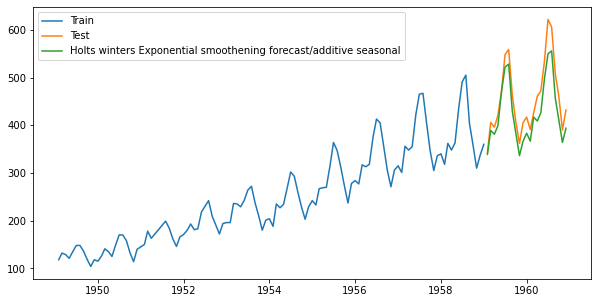

In [316]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_holt_winters_add['hwa_forecast'],label="Holts winters Exponential smoothening forecast/additive seasonal")
plt.legend(loc="best")
plt.show()

In [317]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_holt_winters_add['hwa_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_holt_winters_add['hwa_forecast']))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':["Holt's winters Exponential Smoothening/additive"],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72


In [318]:
# Now check for seasonal multiplicative
y_holt_winters_mul=test.copy()
model=ExponentialSmoothing(train["Passengers"],seasonal_periods=12,trend='add',seasonal='mul')
model_fit=model.fit(optimized=True)
print(model_fit.params)
y_holt_winters_mul['hwa_forecast']=model_fit.forecast(24)

{'smoothing_level': 0.37835567912096624, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.6216443208790338, 'damping_trend': nan, 'initial_level': 126.269014993188, 'initial_trend': 2.8095671839404135, 'initial_seasons': array([0.91416613, 1.00804697, 0.95795742, 0.8828729 , 0.96295747,
       1.04595493, 1.03808526, 0.94597193, 0.82387969, 0.7326028 ,
       0.84683525, 0.84623   ]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


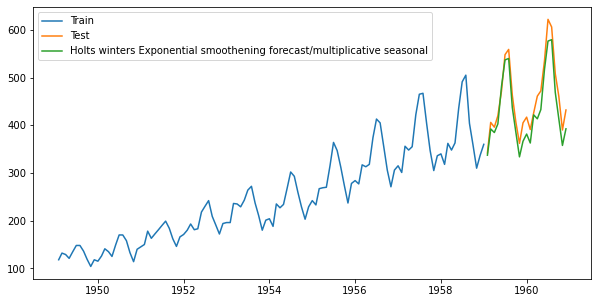

In [319]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_holt_winters_mul['hwa_forecast'],label="Holts winters Exponential smoothening forecast/multiplicative seasonal")
plt.legend(loc="best")
plt.show()

In [320]:
### Evaluation of model
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_holt_winters_mul['hwa_forecast'])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_holt_winters_mul['hwa_forecast']))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':["Holt's winters Exponential Smoothening/multiplicative"],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79


**These are the different smoothing models for forecasting a time series.**

### AUTOREGRESSIVE MODELS

For this we need to check whether our model is stationary or non-stationary

A time series is stationary if its statistical properties (mean, variance) are constant over time. Stationarity is an important assumption in many time series models.
A stationary series does not have a trend or seasonality.

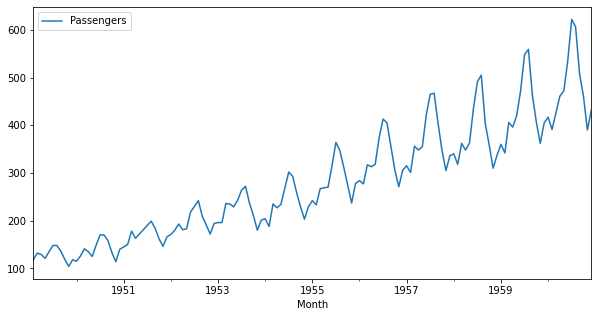

In [321]:
## plot dataset
df["Passengers"].plot(figsize=(10,5))
plt.legend()
plt.show()

From figure itself we can see that time series have trend and seasonality and mean,variance are not constant.we can check stationarity by using statistical test like ADF or KPSS test

### Augmented Dickey-Fuller (ADF) Test
The ADF test is a statistical test used to determine whether a time series has a unit root, which indicates non-stationarity. In other words, it helps to check if a time series is stationary or if it has a trend.

Hypotheses:
Null Hypothesis (
𝐻0
​
 ): The time series has a unit root (i.e., it is non-stationary).
 
Alternative Hypothesis (
𝐻1
​
 ): The time series does not have a unit root (i.e., it is stationary).
 
ADF Test Interpretation:
If the p-value is small (typically less than 0.05), you can reject the null hypothesis, suggesting that the series is stationary.
If the p-value is large (greater than 0.05), you fail to reject the null hypothesis, indicating the series is non-stationary.

In [322]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(df["Passengers"])
print("ADF_statistic: %.2f" % adf_test[0])
print("p-value: %.2f" % adf_test[1])
print("critical-value: %.2f" % adf_test[4]['5%']) # for 5 % 

ADF_statistic: 0.87
p-value: 0.99
critical-value: -2.88


Here p-value >0.05 so we fail to reject null hypothesis.that means series is **not stationary**

### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test
The KPSS test is another statistical test used to check the stationarity of a time series, but unlike the ADF test, it tests for trend stationarity. The KPSS test looks for evidence that a time series is stationary around a deterministic trend.

Hypotheses:
Null Hypothesis (
𝐻0
 ): The time series is trend stationary (stationary around a deterministic trend).
Alternative Hypothesis (
𝐻1
 ): The time series is non-stationary (has a unit root).
 
KPSS Test Interpretation:
If the p-value is small (typically less than 0.05), you reject the null hypothesis, suggesting that the series is non-stationary.

If the p-value is large (greater than 0.05), you fail to reject the null hypothesis, indicating the series is stationary around a deterministic trend.

In [323]:
from statsmodels.tsa.stattools import kpss
kpss_test=kpss(df["Passengers"])
print("KPSS_statistic: %.2f" % kpss_test[0])
print("p-value: %.2f" % kpss_test[1])
print("critical-value: %.2f" % kpss_test[3]['5%']) # for 5 % 

KPSS_statistic: 1.64
p-value: 0.01
critical-value: 0.46


So from test we found that p value<0.05 so we can reject null hypothesis and hence proved that series is not stationary

As we know that our series is non-stationary we need to convert it to stationary for ARmodel to build

### NON STATIONARY TO STATIONARY

#### BOX COX TRANSFORMATION

The Box-Cox transformation is a statistical technique used to stabilize variance and make data more normally distributed.

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0 
\end{cases}
$$
where
y is the original data,
λ is the transformation parameter.


In [324]:
from scipy.stats import boxcox
df_boxcox_result=pd.Series(boxcox(df["Passengers"],lmbda=0),index=df.index)
df_boxcox_result

Month
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Length: 143, dtype: float64

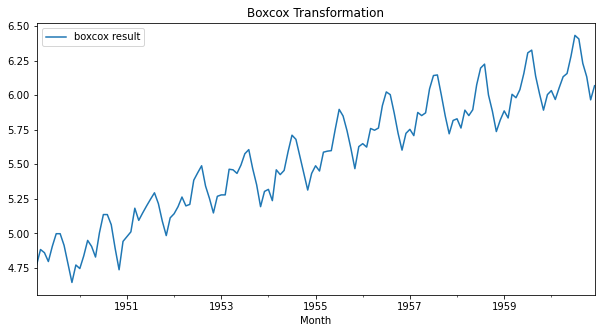

In [325]:
df_boxcox_result.plot(label='boxcox result',figsize=(10,5),title="Boxcox Transformation")
plt.legend(loc="best")
plt.show()

we can see that variance become constant now as lower end and higher end has approx similar magnitude.
But still the plot has positive trend.To reduce it we are using another technique called **Differencing**

#### DIFFERENCING
Differencing is a technique used in time series analysis to make a non-stationary time series stationary. Differencing helps eliminate trends and seasonality in the data by subtracting the previous observation from the current observation.

In [326]:
df_boxcox_diff=df_boxcox_result-df_boxcox_result.shift()

In [327]:
df_boxcox_diff

Month
1949-02-01         NaN
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Length: 143, dtype: float64

In [328]:
# first value is NAN so we are dropping it
df_boxcox_diff.dropna(inplace=True)

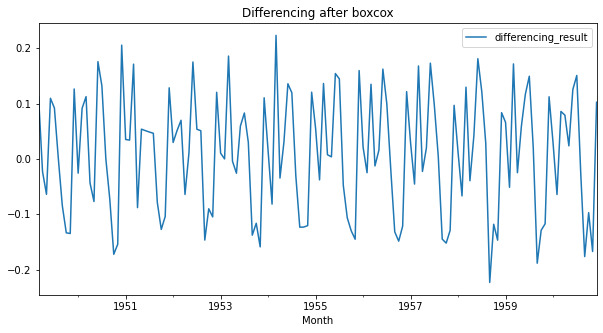

In [329]:
df_boxcox_diff.plot(label='differencing_result',figsize=(10,5),title="Differencing after boxcox")
plt.legend()
plt.show()

Now the data has constant variance and mean.we can test it using statistical test

In [330]:
#Adfuller test
adf_test=adfuller(df_boxcox_diff)
print("ADF_statistic: %.2f" % adf_test[0])
print("p-value: %.2f" % adf_test[1])
print("critical-value: %.2f" % adf_test[4]['5%']) # for 5 % 

ADF_statistic: -3.27
p-value: 0.02
critical-value: -2.88


so here pvalue<0.05 and teststatistic>cv,ao we can reject null hypothesis ie series become stationary

In [331]:
#Kpss test
kpss_test=kpss(df_boxcox_diff)
print("KPSS_statistic: %.2f" % kpss_test[0])
print("p-value: %.2f" % kpss_test[1])
print("critical-value: %.2f" % kpss_test[3]['5%']) # for 5 % 

KPSS_statistic: 0.03
p-value: 0.10
critical-value: 0.46


Here p value >0.05 and test statistic < cv so we cannot reject null hypothesis ie series is stationary

**Now we have converted our series to Stationary**

In [332]:
df_boxcox_diff=pd.DataFrame(df_boxcox_diff)

In [333]:
df_boxcox_diff.columns=['Passengers']

In [334]:
df_boxcox_diff

,Passengers
Month,
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
1949-07-01,0.091937
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


### AUTOCORRELATION 

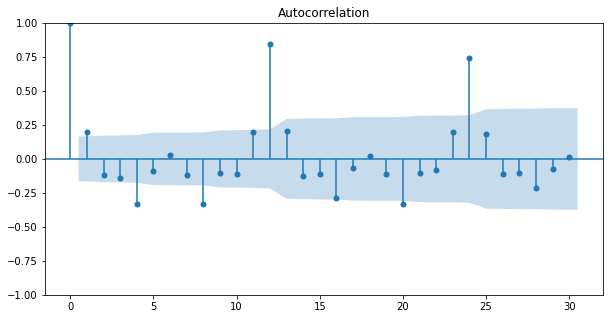

In [335]:
### AutoCorrelationFunction-ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10,5))
plot_acf(df_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

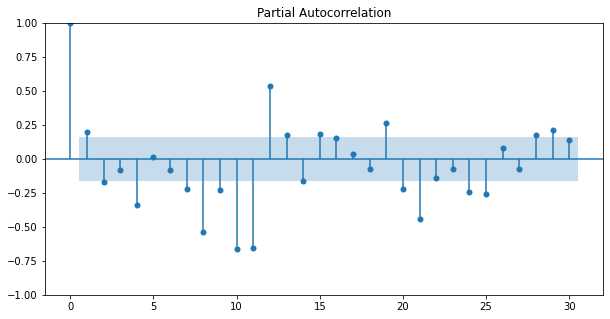

In [336]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,5))
plot_pacf(df_boxcox_diff,ax=plt.gca(),lags=30)
plt.show()

### Simple Auto Regressive Model

In [337]:
## first split stationary series to test and train
train_df_boxcox_diff=df_boxcox_diff[:train_len-1]
test_df_boxcox_diff=df_boxcox_diff[train_len-1:]

In [338]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_df_boxcox_diff,order=(1,0,0))
model_fit=model.fit()

In [339]:
print(model_fit.params)

const     0.009669
ar.L1     0.183729
sigma2    0.010690
dtype: float64


To predict future value on original time series we have to reverse the process of differencing and boxcox

In [340]:
y_ar=df_boxcox_diff.copy()
y_ar['ar_forecast_boxcox_diff']=model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_ar['ar_forecast_boxcox']=y_ar['ar_forecast_boxcox_diff'].cumsum()
y_ar['ar_forecast_boxcox']=y_ar['ar_forecast_boxcox'].add(df_boxcox_result[0]) # add first value back
y_ar['ar_forecast']=np.exp(y_ar['ar_forecast_boxcox'])# reverse boxcox


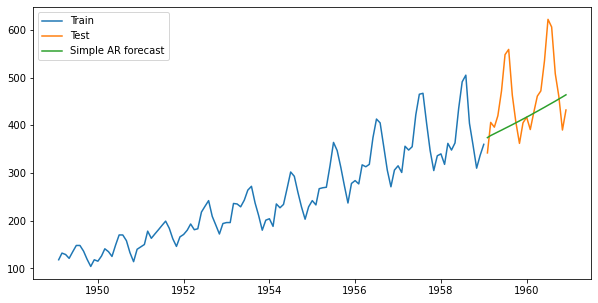

In [341]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_ar['ar_forecast'][test.index.min():],label="Simple AR forecast")
plt.legend(loc="best")
plt.show()

In [342]:
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_ar['ar_forecast'][test.index.min():])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_ar['ar_forecast'][test.index.min():]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_Autoreg'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79
0,Simple_Autoreg,79.66,11.53


### MOVING AVERAGE METHOD
A Moving Average (MA) model is a type of time series model that represents the current value of the series as a linear combination of past errors (or shocks) from a white noise process. Unlike an autoregressive (AR) model, which regresses the current value on past values of the series itself, the MA model uses past error terms.


In [343]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_df_boxcox_diff,order=(0,0,1))
model_fit=model.fit()


In [344]:
print(model_fit.params)

const     0.009664
ma.L1     0.268922
sigma2    0.010519
dtype: float64


Here ma.L1 is coefficient of 1st lag of  error term and sigma2 is the variance of residuals

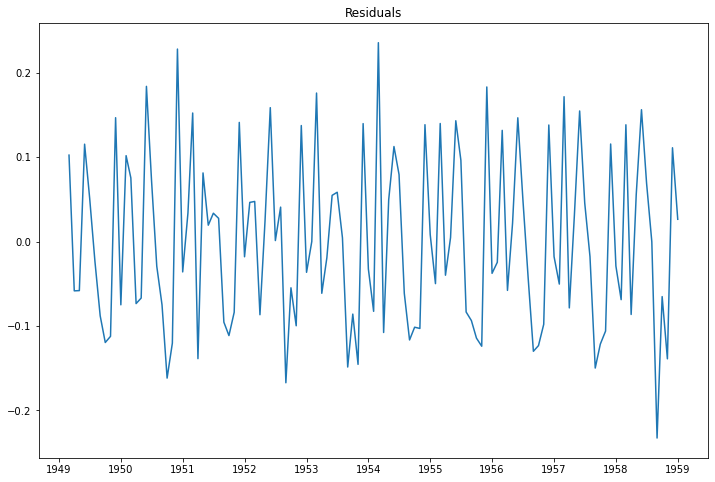

In [345]:
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [346]:
y_ma=df_boxcox_diff.copy()
y_ma['ar_forecast_boxcox_diff']=model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_ma['ar_forecast_boxcox']=y_ma['ar_forecast_boxcox_diff'].cumsum()
y_ma['ar_forecast_boxcox']=y_ma['ar_forecast_boxcox'].add(df_boxcox_result[0]) # add first value to make series to original scale
y_ma['ar_forecast']=np.exp(y_ma['ar_forecast_boxcox'])# reverse boxcox

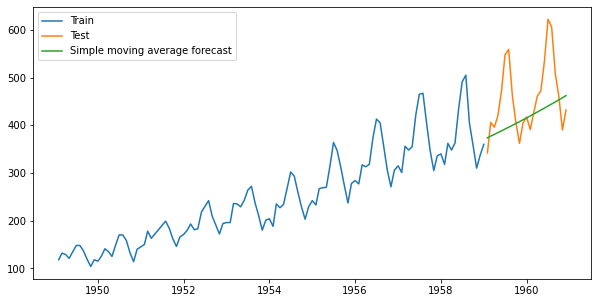

In [347]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_ma['ar_forecast'][test.index.min():],label="Simple moving average forecast")
plt.legend(loc="best")
plt.show()

In [348]:
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_ma['ar_forecast'][test.index.min():])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_ma['ar_forecast'][test.index.min():]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_MovingAverage'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79
0,Simple_Autoreg,79.66,11.53
0,Simple_MovingAverage,80.44,11.68


### AUTOREGRESSIVE MOVING AVERAGE MODEL
ARMA (Autoregressive Moving Average) models combine two key components, the Autoregressive (AR) and the Moving Average (MA) models, to analyze and forecast time series data. ARMA is useful for capturing both the persistence of values in a time series (through the AR part) and the influence of past error terms (through the MA part).

In [382]:
model=ARIMA(train_df_boxcox_diff,order=(1,0,1))
model_fit=model.fit()
model_fit.params


const     0.009219
ar.L1    -0.534415
ma.L1     0.803353
sigma2    0.010039
dtype: float64

In [350]:
y_arma=df_boxcox_diff.copy()
y_arma['ar_forecast_boxcox_diff']=model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_arma['ar_forecast_boxcox1']=y_arma['ar_forecast_boxcox_diff'].cumsum()
y_arma['ar_forecast_boxcox']=y_arma['ar_forecast_boxcox1'].add(df_boxcox_result[0]) # add first value to make series to original scale
y_arma['ar_forecast']=np.exp(y_arma['ar_forecast_boxcox'])# reverse boxcox

In [351]:
y_arma

,Passengers,ar_forecast_boxcox_diff,ar_forecast_boxcox1,ar_forecast_boxcox,ar_forecast
Month,,,,,
1949-03-01,0.112117,0.009219,0.009219,4.779903,119.092826
1949-04-01,-0.022990,0.029292,0.038511,4.809196,122.632923
1949-05-01,-0.064022,-0.013217,0.025294,4.795978,121.022723
1949-06-01,0.109484,0.008969,0.034263,4.804948,122.113081
1949-07-01,0.091937,0.034606,0.068869,4.839554,126.412926
...,...,...,...,...,...
1960-08-01,-0.026060,0.009218,1.268709,6.039393,419.638427
1960-09-01,-0.176399,0.009219,1.277928,6.048612,423.524892
1960-10-01,-0.097083,0.009218,1.287146,6.057831,427.447203


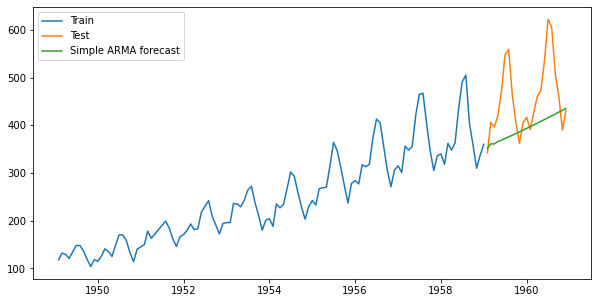

In [352]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_arma['ar_forecast'][test.index.min():],label="Simple ARMA forecast")
plt.legend(loc="best")
plt.show()

In [353]:
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_arma['ar_forecast'][test.index.min():])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_arma['ar_forecast'][test.index.min():]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_ARMA'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79
0,Simple_Autoreg,79.66,11.53
0,Simple_MovingAverage,80.44,11.68
0,Simple_ARMA,93.42,13.82


### ARIMA (AutoRegressive Integrated Moving Average) 
ARIMA is a powerful and widely used time series forecasting technique that models the behavior of a time series by incorporating three main components: autoregression (AR), differencing (I), and moving averages (MA). It is particularly effective for data that shows non-stationarity

Components of ARIMA:
ARIMA is represented as ARIMA(p, d, q), where:

p: The number of lag observations (past values) included in the model (autoregressive part).

d: The number of times the data has to be differenced to make it stationary (integrated part).

q: The number of lagged forecast errors (moving average part).

In [354]:
## first split boxcox series to test and train
train_df_boxcox=df_boxcox_result[:train_len]
test_df_boxcox=df_boxcox_result[train_len:]

In [380]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_df_boxcox,order=(1,1,1))
model_fit=model.fit()
model_fit.params

ar.L1    -0.530307
ma.L1     0.802589
sigma2    0.010100
dtype: float64

In [383]:
y_arima=df_boxcox_diff.copy()
y_arima['arima_forecast_boxcox_diff']=model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_arima['arima_forecast_boxcox1']=y_arima['arima_forecast_boxcox_diff'].cumsum()
y_arima['arima_forecast_boxcox']=y_arima['arima_forecast_boxcox1'].add(df_boxcox_result[0]) # add first value to make series to original scale
y_arima['arima_forecast']=np.exp(y_arima['arima_forecast_boxcox'])# reverse boxcox
y_arima

,Passengers,arima_forecast_boxcox_diff,arima_forecast_boxcox1,arima_forecast_boxcox,arima_forecast
Month,,,,,
1949-03-01,0.112117,0.009219,0.009219,4.779903,119.092826
1949-04-01,-0.022990,0.029292,0.038511,4.809196,122.632923
1949-05-01,-0.064022,-0.013217,0.025294,4.795978,121.022723
1949-06-01,0.109484,0.008969,0.034263,4.804948,122.113081
1949-07-01,0.091937,0.034606,0.068869,4.839554,126.412926
...,...,...,...,...,...
1960-08-01,-0.026060,0.009218,1.268709,6.039393,419.638427
1960-09-01,-0.176399,0.009219,1.277928,6.048612,423.524892
1960-10-01,-0.097083,0.009218,1.287146,6.057831,427.447203


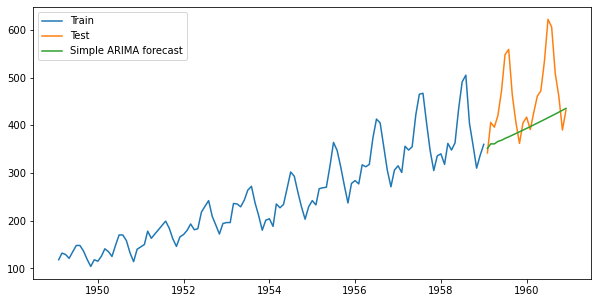

In [384]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_arima['arima_forecast'][test.index.min():],label="Simple ARIMA forecast")
plt.legend(loc="best")
plt.show()

In [386]:
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_arima['arima_forecast'][test.index.min():])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_arima['arima_forecast'][test.index.min():]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_ARIMA'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79
0,Simple_Autoreg,79.66,11.53
0,Simple_MovingAverage,80.44,11.68
0,Simple_ARMA,93.42,13.82


### Seasonal AutoRegressive Integrated Moving Average
SARIMA (Seasonal AutoRegressive Integrated Moving Average) is an extension of the ARIMA model that explicitly models the seasonal components in time series data. While ARIMA handles non-stationary data with trends, SARIMA is designed to handle both trends and seasonality by including seasonal parameters.

In [404]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train_df_boxcox,order=(1,1,1),seasonal_order=(1,1,1,12))

In [405]:
model_fit=model.fit()
print(model_fit.params)

ar.L1       0.389536
ma.L1      -0.689925
ar.S.L12   -0.049408
ma.S.L12   -0.510071
sigma2      0.001415
dtype: float64


In [406]:
y_sarima=df_boxcox_diff.copy()
y_sarima['sarima_forecast_boxcox']=model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_sarima['sarima_forecast']=np.exp(y_sarima['sarima_forecast_boxcox'])

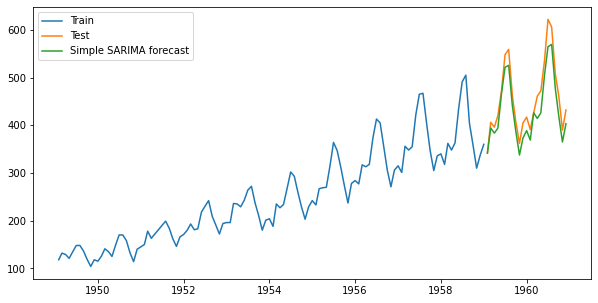

In [407]:
#plot train,test,forecast
plt.figure(figsize=(10,5))
plt.plot(train['Passengers'],label="Train")
plt.plot(test['Passengers'],label="Test")
plt.plot(y_sarima['sarima_forecast'][test.index.min():],label="Simple SARIMA forecast")
plt.legend(loc="best")
plt.show()

In [392]:
RMSE=np.sqrt(mean_squared_error(test['Passengers'],y_sarima['sarima_forecast'][test.index.min():])).round(2)
MAPE=round(np.mean((np.abs(test['Passengers']-y_sarima['sarima_forecast'][test.index.min():]))/test['Passengers'])*100,2)
temp=pd.DataFrame({'Method':['Simple_SARIMA'],'RMSE':[RMSE],'MAPE':[MAPE]})
result=pd.concat([result,temp])
result

,Method,RMSE,MAPE
0,Naive_method,121.40,19.68
0,Simple_Average,221.20,44.36
0,Simple_Moving_Average,104.28,15.67
0,Simple Exponential Smoothening,112.15,17.55
0,Holt's Exponential Smoothening,94.68,13.82
0,Holt's winters Exponential Smoothening/additive,35.70,6.72
0,Holt's winters Exponential Smoothening/multipl...,29.46,5.79
0,Simple_Autoreg,79.66,11.53
0,Simple_MovingAverage,80.44,11.68
0,Simple_ARMA,93.42,13.82


So SARIMA can better predict future values better than other models and also reduce RMSE and MAPE indicates that the performance of a model is better.The model exhibits a relatively decent performance and we can better improve model using hyperparameters

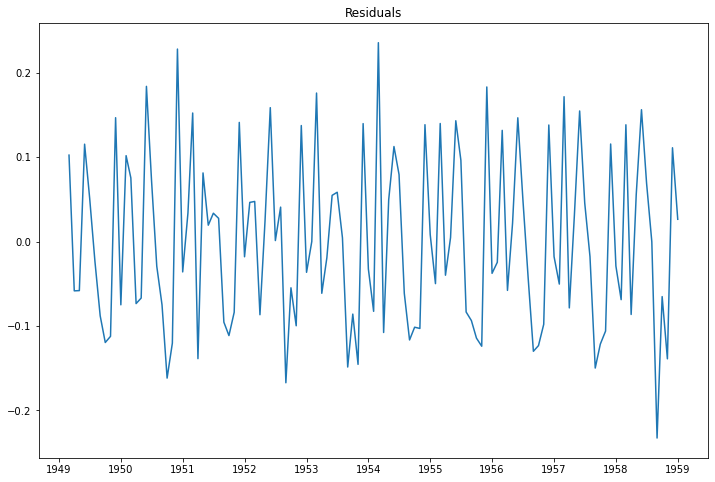

In [408]:
model_fit.resid
plt.plot(residuals)
plt.title('Residuals')
plt.show()

The residuals are randomly scattered around the zero line,the spread of the residuals remains fairly consistent across the range of fitted values and there are no discernible patterns such as curves or waves, which suggests that the model has captured the underlying trend in the data well